# **Neural Network from scratch**

.

.

In [86]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

import warnings
warnings.filterwarnings("ignore")

.

## **Define useful functions**

Initializing the weights to zero is not recommended. Andrew Ng (in his the online course about Machine Learning on Coursera) suggests the following initialization:

In [87]:
#Random initialization of weights
def randw(Lin,Lout) :
    np.random.seed(0)
    epsilon = (6 / (Lin+Lout))**0.5;
    return np.random.rand(Lout,Lin+1)*2*epsilon - epsilon

.

Different activation functions can be used in a Neural Network.

In [88]:
#Activation function
def act(a,x) :
    if a=="sigmoid" :
        return 1./(1.+np.exp(-x))
    elif a=="tanh" :
        return np.tanh(x)
    elif a=="relu" :
        return np.where(x>=0,x,0)

.

The *forward propagation* is useful to fo from the input layer to the output layer.

In [89]:
#Forward propagation
#Only one function will be applied to the whole net
#The function in the last layer is always the Sigmoid (BINARY CLASSIFICATION)
def Forward(X,theta1,theta2,function,theta3=None) :
    m = X.shape[0]
    a2 = act(function,np.dot(theta1,X.T))          #a1=X.T
    if theta3 is None :
        a3 = act("sigmoid",np.dot(theta2,np.vstack([np.ones((1,m)),a2])))   
        return a3.T
    else :
        a3 = act(function,np.dot(theta2,np.vstack([np.ones((1,m)),a2])))   
        a4 = act("sigmoid",np.dot(theta3,np.vstack([np.ones((1,m)),a3])))
        return a4.T

.

The Neural Network training requires the full *forward and back propagation* algorithm to optimize the weights by computing the gradient of the cost function.

In [101]:
#Forward and Backpropagation
#Only one function will be applied to the whole net
#The function in the last layer is always the Sigmoid (BINARY CLASSIFICATION)
def ForwBack(X,theta1,theta2, yy, function, theta3=None) :
    m = X.shape[0]
    a2 = act(function,np.dot(theta1,X.T))          #a1=X.T
    if theta3 is None :
        a3 = act("sigmoid",np.dot(theta2,np.vstack([np.ones((1,m)),a2])))   
        d3 = a3-yy.T
        if function == "sigmoid" :              #Derivative Sigmoid: sigma' = sigma*(1-sigma)
            d2 = np.dot(theta2.T,d3) * np.vstack([np.ones((1,m)),a2]) * (1 - np.vstack([np.ones((1,m)),a2]))
        elif function == "tanh" :               #Derivative Tanh: sigma' = 1-sigma**2
            d2 = np.dot(theta2.T,d3) * (1 - (np.vstack([np.ones((1,m)),a2]))**2)
        else :                                  #Derivative relu: sigma'= 1 for x>0, 0 elsewhere
            d2 = np.dot(theta2.T,d3) * (np.vstack([np.ones((1,m)),np.where(a2>=0,1,0)]))
        a4, d4 = 0,0
        return a2, a3, a4, d2, d3, d4
    else :
        a3 = act(function,np.dot(theta2,np.vstack([np.ones((1,m)),a2])))   
        a4 = act("sigmoid",np.dot(theta3,np.vstack([np.ones((1,m)),a3])))
        d4 = a4-yy.T
        if function == "sigmoid" :        
            d3 = (np.dot(theta3.T,d4) * np.vstack([np.ones((1,m)),a3]) * (1 - np.vstack([np.ones((1,m)),a3])))[1:,:]
            d2 = (np.dot(theta2.T,d3) * np.vstack([np.ones((1,m)),a2]) * (1 - np.vstack([np.ones((1,m)),a2])))[1:,:]
        elif function == "tanh" :               
            d3 = (np.dot(theta3.T,d4) * (1 - (np.vstack([np.ones((1,m)),a3]))**2 ))[1:,:]
            d2 = (np.dot(theta2.T,d3) * (1 - (np.vstack([np.ones((1,m)),a2]))**2 ))[1:,:]
        else :
            d3 = (np.dot(theta3.T,d4) * (np.vstack([np.ones((1,m)),np.where(a3>=0,1,0)])))[1:,:]
            d2 = (np.dot(theta2.T,d3) * (np.vstack([np.ones((1,m)),np.where(a2>=0,1,0)])))[1:,:]
        return a2, a3, a4, d2, d3, d4

.

Finally, it is possible to create the Cost function and its gradient: in this function, the L2 regularization is added in the code.

In [91]:
#Cost function and Gradient
def J_Grad(theta1, theta2, X, y, hid_layer1, labels, Lambda, function, theta3 = None, hid_layer2 = None) :
    m = X.shape[0]
    inputs = X.shape[1]
    X = np.hstack([np.ones((X.shape[0],1)),X])
    
    #Create target array
    yy = np.zeros((len(y),labels))
    for i in np.arange(0,m) :
        for k in np.arange(0,labels) :
            if y[i] == k :
                yy[i,k] = 1
    
    a2, a3, a4, d2, d3, d4 = ForwBack(X=X, theta1=theta1, theta2=theta2, theta3=theta3, yy=yy, function=function)
    if hid_layer2 is None :
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))*Lambda/(2*m)  
        J = sum(sum(-np.log10(a3)*yy.T - np.log10(1-a3)*(1-yy).T))/m + REG
        Delta1 = np.dot(d2,X)[1:,:]       #(d2,a1.T)
        Delta2 = np.dot(d3,(np.vstack([np.ones((1,m)),a2])).T)
        t1grad = (Delta1+(np.hstack([ np.zeros((theta1.shape[0],1)), theta1[:,1:]  ]))*Lambda)/m
        t2grad = (Delta2+(np.hstack([ np.zeros((theta2.shape[0],1)), theta2[:,1:]  ]))*Lambda)/m
        t3grad = 0    
    else :
        REG = (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2) + np.sum(theta3[:,1:]**2))*Lambda/(2*m)  
        J = sum(sum(-np.log10(a4)*yy.T - np.log10(1-a4)*(1-yy).T))/m + REG
        Delta1 = np.dot(d2,X)
        Delta2 = np.dot(d3,(np.vstack([np.ones((1,m)),a2])).T)
        Delta3 = np.dot(d4,(np.vstack([np.ones((1,m)),a3])).T)
        t1grad = (Delta1+(np.hstack([ np.zeros((theta1.shape[0],1)), theta1[:,1:]  ]))*Lambda)/m
        t2grad = (Delta2+(np.hstack([ np.zeros((theta2.shape[0],1)), theta2[:,1:]  ]))*Lambda)/m
        t3grad = (Delta3+(np.hstack([ np.zeros((theta3.shape[0],1)), theta3[:,1:]  ]))*Lambda)/m
    return J, t1grad, t2grad, t3grad

.

Once weights have been optimized, the following function returns the final probabilities, predictions, and accuracy.

In [92]:
def Accuracy(theta1, theta2, X, y, function, theta3 = None) :
    m = X.shape[0]
    inputs = X.shape[1]
    X = np.hstack([np.ones((X.shape[0],1)),X])
    final = Forward(X,theta1,theta2,theta3=theta3,function=function)
    Pred = []
    for i in np.arange(0,len(final)) :
        Pred.append(np.argmax(final[i,:]))
    return final[:,1], Pred, (Pred == y).sum()/len(y)

.

All the pieces are ready to write the Neural Network training function that implements the forward and back propagation algorithm up to a *Max_iter* iteration.

The following code includes the *early stopping* part: once the cost function on the validation set reaches its minimum, the algorithm stops to avoid overfitting.

The function return the last iteration epoch, the matrices of weights, the training and validation cost function values at the last iteration, and the corresponding accuracies.

In [93]:
#Training Neural Network
def Training(hid_layer1, X, y, X_test, y_test, alpha, Lambda, Max_iter, function, hid_layer2 = None, flag = True) :
    inputs = X.shape[1]                     #Number of features
    labels = len(pd.Series(y).unique())     #Number of labels (in the output)
    Cost_te = 100
    if hid_layer2 is None :
        #Random initialization of weights
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, labels)
        theta3 = None
    else :
        theta1 = randw(inputs, hid_layer1)
        theta2 = randw(hid_layer1, hid_layer2)
        theta3 = randw(hid_layer2, labels)

    #Iterative training (i: epoch)
    Cost, Cost_t = [], []
    for i in range(Max_iter) :
        A, B, C, D = J_Grad(theta1=theta1, theta2=theta2, theta3=theta3, X=X, y=y, hid_layer1=hid_layer1, 
                            hid_layer2=hid_layer2, labels=labels, Lambda=Lambda, function=function)
        A1, B1, C1, D1 = J_Grad(theta1=theta1, theta2=theta2, theta3=theta3, X=X_test, y=y_test, hid_layer1=hid_layer1, 
                                hid_layer2=hid_layer2, labels=labels, Lambda=0.0, function=function)
        EE, E, F = Accuracy(theta1=theta1, theta2=theta2, theta3=theta3, X=X, y=y, function=function)
        EE1, E1, F1 = Accuracy(theta1=theta1, theta2=theta2, theta3=theta3, X=X_test, y=y_test, function=function)
        Cost.append(A)
        Cost_t.append(A1)
        
        #Early stopping
        broken = 0
        if (flag == True) & (i>100) :        #To avoid initial flactuations
            if A1<Cost_te :
                Cost_te = A1
            else :
                broken = 1
        if broken==1 :
            break
            
        #Update weights
        if hid_layer2 is None :
            theta1 = theta1 - alpha*B
            theta2 = theta2 - alpha*C
        else :
            theta1 = theta1 - alpha*B
            theta2 = theta2 - alpha*C
            theta3 = theta3 - alpha*D
        i=i+1
    return i, theta1, theta2, theta3, Cost, Cost_t, F, F1

.

## **Dataset**

The dataset has been retrieved from https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names : it is about the *Pima Indians Diabetes*.

In [94]:
#Import the data
data = pd.read_csv("dati2")
data

,A,B,C,D,E,F,G,H,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


.

The features are all numeric:
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

In [95]:
#Missing values
print("Number of missing values: {}".format(data.isna().sum().sum()))

Number of missing values: 0


.

The dataset has no missing values. Let's take a look at the target variable:

In [96]:
#Target variable
data.Class.value_counts()

0    500
1    268
Name: Class, dtype: int64

.

It is an unbalanced dataset. In this first part, let's work with a perfectly balanced dataset.

In [97]:
#Create a balanced dataset (268 records for each class)
data_bal = pd.concat([data[data.Class==0].sample(268, random_state=0),data[data.Class==1]])

#Creation of X and y
X = data_bal.drop(["Class"],axis=1)
y = data_bal.Class
X = np.array(X)
y = np.array(y)

In [98]:
#Training and test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

.

Before applying the algorithm, let's scale the features.

In [99]:
#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

.

## **Training (balanced dataset)**

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Activation function
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score

In [103]:
#Grid search
hid_layer1 = [2,3,5]
hid_layer2 = [None, 2,5]
learning_rate = [0.5,0.8,1.0]
functions = ["sigmoid","tanh","relu"]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s = [], [], [], [], []
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                    q,w,e,r,t,yh,u,p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, 
                                                X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, 
                                                Lambda=0.0, Max_iter = 1000, function=f)
                    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t, function=f)
                    acc.append(u), acc_te.append(p)
                    pre.append(precision_score(y_test_t, y_pred))
                    rec.append(recall_score(y_test_t, y_pred))
                    f1s.append(f1_score(y_test_t, y_pred))
                print("{} - {} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f}".format(i,j,a,f,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                                                           np.mean(pre), np.mean(rec),np.mean(f1s)))

2 - None - 0.5 - sigmoid ----- 0.754 (0.007) - 0.712 (0.025) - 0.705 - 0.738 - 0.716
2 - None - 0.5 - tanh ----- 0.758 (0.009) - 0.728 (0.026) - 0.716 - 0.764 - 0.735
2 - None - 0.5 - relu ----- 0.743 (0.006) - 0.725 (0.025) - 0.760 - 0.668 - 0.706
2 - None - 0.8 - sigmoid ----- 0.761 (0.009) - 0.725 (0.011) - 0.710 - 0.774 - 0.736
2 - None - 0.8 - tanh ----- 0.749 (0.010) - 0.712 (0.025) - 0.711 - 0.727 - 0.713
2 - None - 0.8 - relu ----- 0.739 (0.010) - 0.677 (0.023) - 0.717 - 0.592 - 0.645
2 - None - 1.0 - sigmoid ----- 0.765 (0.012) - 0.749 (0.023) - 0.733 - 0.793 - 0.758
2 - None - 1.0 - tanh ----- 0.731 (0.032) - 0.685 (0.040) - 0.682 - 0.736 - 0.689
2 - None - 1.0 - relu ----- 0.679 (0.042) - 0.624 (0.061) - 0.796 - 0.366 - 0.473
2 - 2 - 0.5 - sigmoid ----- 0.518 (0.017) - 0.483 (0.058) - 0.304 - 0.483 - 0.350
2 - 2 - 0.5 - tanh ----- 0.741 (0.017) - 0.720 (0.019) - 0.702 - 0.811 - 0.740
2 - 2 - 0.5 - relu ----- 0.567 (0.074) - 0.509 (0.094) - 0.429 - 0.704 - 0.514
2 - 2 - 0.8 -

.

The best model (i.e. high validation accuracy, small standard deviation) is:
- Number of units in the first hidden layer: 3
- No second hidden layer
- Learning rate: 1.0
- Activation function: Sigmoid

Let's try some tuning.

In [106]:
#Grid search
hid_layer1 = [3,4]
hid_layer2 = [None]
learning_rate = [0.9,1.0,1.1,1.2,1.3,1.4]
functions = ["sigmoid"]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s = [], [], [], [], []
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                    q,w,e,r,t,yh,u,p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, 
                                                X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, 
                                                Lambda=0.0, Max_iter = 1000, function=f)
                    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t, function=f)
                    acc.append(u), acc_te.append(p)
                    pre.append(precision_score(y_test_t, y_pred))
                    rec.append(recall_score(y_test_t, y_pred))
                    f1s.append(f1_score(y_test_t, y_pred))
                print("{} - {} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f}".format(i,j,a,f,np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                                                           np.mean(pre), np.mean(rec),np.mean(f1s)))

3 - None - 0.9 - sigmoid ----- 0.762 (0.008) - 0.739 (0.007) - 0.738 - 0.752 - 0.740
3 - None - 1.0 - sigmoid ----- 0.765 (0.009) - 0.752 (0.018) - 0.755 - 0.757 - 0.751
3 - None - 1.1 - sigmoid ----- 0.768 (0.009) - 0.757 (0.016) - 0.764 - 0.752 - 0.754
3 - None - 1.2 - sigmoid ----- 0.769 (0.007) - 0.757 (0.013) - 0.761 - 0.757 - 0.756
3 - None - 1.3 - sigmoid ----- 0.759 (0.010) - 0.747 (0.022) - 0.739 - 0.765 - 0.749
3 - None - 1.4 - sigmoid ----- 0.756 (0.006) - 0.733 (0.024) - 0.727 - 0.763 - 0.739
4 - None - 0.9 - sigmoid ----- 0.755 (0.009) - 0.720 (0.008) - 0.714 - 0.747 - 0.725
4 - None - 1.0 - sigmoid ----- 0.756 (0.010) - 0.723 (0.010) - 0.715 - 0.752 - 0.728
4 - None - 1.1 - sigmoid ----- 0.759 (0.010) - 0.725 (0.011) - 0.720 - 0.746 - 0.728
4 - None - 1.2 - sigmoid ----- 0.762 (0.008) - 0.731 (0.013) - 0.725 - 0.751 - 0.733
4 - None - 1.3 - sigmoid ----- 0.762 (0.012) - 0.725 (0.014) - 0.717 - 0.751 - 0.730
4 - None - 1.4 - sigmoid ----- 0.757 (0.009) - 0.725 (0.026) - 0.

.

The best model (i.e. high validation accuracy, small standard deviation) is:
- Number of units in the first hidden layer: 3
- No second hidden layer
- Learning rate: 1.2
- Activation function: Sigmoid

.

Let's take a look at the performance on the Test set: let's plot the cost function for the training and test set to see when early stopping can be applied (flag=False).

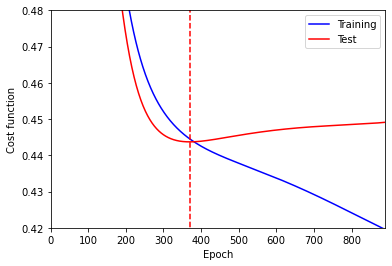

In [111]:
#Performance on the Test set
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 1.2, function = "sigmoid", 
                            X = X_train, y = y_train, X_test = X_test, y_test = y_test, 
                            Lambda=0.0, Max_iter = 1000, flag=False)

#Plot cost functions
plt.plot(t,'blue')
plt.plot(yh,'red')
plt.plot([371,371],[0.3,0.6],'--r')
plt.xlim([0,890])
plt.ylim([0.42,0.48])
plt.xlabel("Epoch")
plt.ylabel("Cost function")
plt.legend(["Training","Test"])

.

At epoch ~400, the Test cost function starts to increase. That is the point where overfit starts.

Now, let's use early stopping in the training function (flag = True).

Last iteration: 371 --- Train accuracy: 76.0% - Test accuracy: 73.91304347826086%

Precision:  0.7702702702702703
Recall:  0.6951219512195121
F1-score:  0.7307692307692307




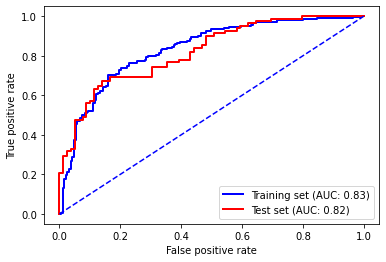

In [112]:
#Performance on the Test set
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 1.2, function = "sigmoid",
                            X = X_train, y = y_train, X_test = X_test, y_test = y_test,
                            Lambda=0.0, Max_iter = 5000, flag=True)
print("Last iteration: {} --- Train accuracy: {}% - Test accuracy: {}%".format(q,100*u,100*p))


#Confusion matrix
EE, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_test, y=y_test, function = "sigmoid")
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))
print("\n")
Conf_matrix


#ROC curves
EE1, y_pred, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train, function = "sigmoid")
fpr1, tpr1, thresholds1 = roc_curve(y_train,EE1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,EE)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,EE1)),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,EE))], loc="lower right")

.

For comparison, let's use the Logistic Regression model on the same dataset.


Logistic training accuracy:  0.7546666666666667
Logistic test accuracy:  0.7391304347826086

Precision:  0.7941176470588235
Recall:  0.6585365853658537
F1-score:  0.72




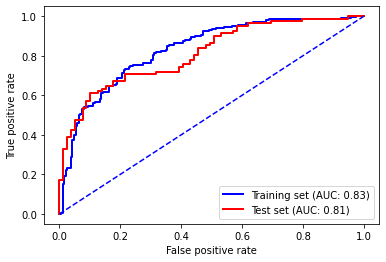

In [113]:
#For comparison: Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train,y_train)
print("\nLogistic training accuracy: ", Model_log.score(X_train,y_train))
print("Logistic test accuracy: ", Model_log.score(X_test,y_test))

#Confusion matrix
y_pred_log = Model_log.predict(X_test)
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred_log))
print("Recall: ", recall_score(y_test, y_pred_log))
print("F1-score: ", f1_score(y_test, y_pred_log))
print("\n")
Conf_matrix_log


#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train,Model_log.predict_proba(X_train)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test,Model_log.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,Model_log.predict_proba(X_train)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test,Model_log.predict_proba(X_test)[:,1]))], loc="lower right")

.

Only one small difference between the two models.

.

.

.

## **Training (unbalanced dataset)**

Now, let's use the whole unbalanced dataset.

In [114]:
#Creation of X and y (from the unbalanced dataset)
X = data.drop(["Class"],axis=1)
y = data.Class
X = np.array(X)
y = np.array(y)

#Training and test set (70-30%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

.

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Activation function
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score
 - Mean training AUC
 - Mean test AUC

In [115]:
#Grid search
hid_layer1 = [2,3,5]
hid_layer2 = [None, 2,5]
learning_rate = [0.5,0.8,1.0]
functions = ["sigmoid","tanh","relu"]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s, auc, auc_te = [], [], [], [], [], [], []
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                    q,w,e,r,t,yh,u,p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, 
                                                X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, 
                                                Lambda=0.0, Max_iter = 1000, function=f)
                    EE1, y_pred1, F1 = Accuracy(theta1=w, theta2=e, theta3=r, X=X_train_t, y=y_train_t, function=f)
                    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t, function=f)
                    acc.append(u), acc_te.append(p)
                    pre.append(precision_score(y_test_t, y_pred))
                    rec.append(recall_score(y_test_t, y_pred))
                    f1s.append(f1_score(y_test_t, y_pred))
                    auc.append(roc_auc_score(y_train_t,EE1))
                    auc_te.append(roc_auc_score(y_test_t,EE))
                    
                    
                print("{} - {} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f} --- {:.3f} - {:.3f}".format(i,j,a,f,
                                                                    np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                    np.mean(pre), np.mean(rec),np.mean(f1s),
                                                                    np.mean(auc),np.mean(auc_te)))

2 - None - 0.5 - sigmoid ----- 0.753 (0.009) - 0.772 (0.033) - 0.710 - 0.617 - 0.658 --- 0.830 - 0.836
2 - None - 0.5 - tanh ----- 0.766 (0.005) - 0.776 (0.020) - 0.708 - 0.631 - 0.666 --- 0.835 - 0.837
2 - None - 0.5 - relu ----- 0.764 (0.002) - 0.787 (0.021) - 0.759 - 0.589 - 0.662 --- 0.832 - 0.832
2 - None - 0.8 - sigmoid ----- 0.766 (0.007) - 0.772 (0.015) - 0.704 - 0.626 - 0.661 --- 0.838 - 0.838
2 - None - 0.8 - tanh ----- 0.760 (0.003) - 0.769 (0.030) - 0.697 - 0.626 - 0.657 --- 0.831 - 0.837
2 - None - 0.8 - relu ----- 0.747 (0.007) - 0.761 (0.031) - 0.725 - 0.540 - 0.612 --- 0.824 - 0.834
2 - None - 1.0 - sigmoid ----- 0.770 (0.009) - 0.770 (0.009) - 0.698 - 0.626 - 0.658 --- 0.841 - 0.841
2 - None - 1.0 - tanh ----- 0.755 (0.008) - 0.770 (0.030) - 0.704 - 0.622 - 0.657 --- 0.828 - 0.836
2 - None - 1.0 - relu ----- 0.697 (0.027) - 0.698 (0.041) - 0.816 - 0.204 - 0.319 --- 0.808 - 0.814
2 - 2 - 0.5 - sigmoid ----- 0.637 (0.005) - 0.644 (0.019) - 0.000 - 0.000 - 0.000 --- 0.750

.

The best model (i.e. high validation AUC, high validation accuracy, high f1-score, precision and recall, small std on accuracies) is
- Number of units in the first hidden layer: 3
- Number of units in the second hidden layer: None
- Learning rate: 0.5
- Activation function: tanh

Let's try some tuning.

In [119]:
#Grid search
hid_layer1 = [3,4]
hid_layer2 = [None]
learning_rate = [0.1,0.2,0.3,0.4,0.5,0.6,0.7]
functions = ["tanh"]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
                acc, acc_te, pre, rec, f1s, auc, auc_te = [], [], [], [], [], [], []
                for k in range(5) :
                    #Split Training set into training and validation sets (5 random sampling)
                    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
                    q,w,e,r,t,yh,u,p = Training(hid_layer1 = i, hid_layer2 = j, alpha = a, 
                                                X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, 
                                                Lambda=0.0, Max_iter = 1000, function=f)
                    EE1, y_pred1, F1 = Accuracy(theta1=w, theta2=e, theta3=r, X=X_train_t, y=y_train_t, function=f)
                    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t, function=f)
                    acc.append(u), acc_te.append(p)
                    pre.append(precision_score(y_test_t, y_pred))
                    rec.append(recall_score(y_test_t, y_pred))
                    f1s.append(f1_score(y_test_t, y_pred))
                    auc.append(roc_auc_score(y_train_t,EE1))
                    auc_te.append(roc_auc_score(y_test_t,EE))
                    
                print("{} - {} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) - {:.3f} - {:.3f} - {:.3f} --- {:.3f} - {:.3f}".format(i,j,a,f,
                                                                    np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te), 
                                                                    np.mean(pre), np.mean(rec),np.mean(f1s),
                                                                    np.mean(auc),np.mean(auc_te)))

3 - None - 0.1 - tanh ----- 0.767 (0.010) - 0.778 (0.029) - 0.717 - 0.627 - 0.667 --- 0.835 - 0.841
3 - None - 0.2 - tanh ----- 0.773 (0.004) - 0.787 (0.013) - 0.736 - 0.631 - 0.677 --- 0.849 - 0.850
3 - None - 0.3 - tanh ----- 0.773 (0.005) - 0.781 (0.016) - 0.731 - 0.615 - 0.665 --- 0.852 - 0.855
3 - None - 0.4 - tanh ----- 0.777 (0.005) - 0.783 (0.019) - 0.731 - 0.621 - 0.669 --- 0.854 - 0.856
3 - None - 0.5 - tanh ----- 0.772 (0.003) - 0.780 (0.018) - 0.717 - 0.631 - 0.670 --- 0.846 - 0.847
3 - None - 0.6 - tanh ----- 0.769 (0.005) - 0.776 (0.022) - 0.712 - 0.626 - 0.665 --- 0.842 - 0.843
3 - None - 0.7 - tanh ----- 0.766 (0.006) - 0.778 (0.024) - 0.717 - 0.626 - 0.667 --- 0.839 - 0.842
4 - None - 0.1 - tanh ----- 0.770 (0.005) - 0.778 (0.019) - 0.731 - 0.600 - 0.657 --- 0.840 - 0.842
4 - None - 0.2 - tanh ----- 0.772 (0.004) - 0.783 (0.022) - 0.728 - 0.627 - 0.672 --- 0.849 - 0.846
4 - None - 0.3 - tanh ----- 0.774 (0.005) - 0.791 (0.017) - 0.740 - 0.637 - 0.683 --- 0.852 - 0.849


.

The best model (i.e. high validation AUC, high validation accuracy, high f1-score, precision and recall, small std on accuracies) is
- Number of units in the first hidden layer: 3
- Number of units in the second hidden layer: None
- Learning rate: 0.4
- Activation function: tanh

.


Now, it is possible to try to find the threshold that maximizes the f1-score.

Best threshold: 0.44
Largest f1-score: 0.7115324453494044


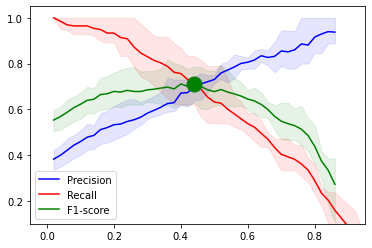

In [120]:
#Repeated random sampling (iterations: 5)
for k in range(5) :
    #Split Training set into training and validation sets (5 random sampling)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train,y_train,test_size=0.2,random_state=k)
    q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 0.4, function = "tanh",
                                X = X_train_t, y = y_train_t, X_test = X_test_t, y_test = y_test_t, 
                                Lambda=0.0, Max_iter = 5000, flag=True)
    EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test_t, y=y_test_t,function = "tanh")
    
    Thresh = np.arange(0.02,1.02,0.02)
    exec(f"Pre_{k}, Rec_{k} = [],[]")
    Rec = []
    for j in Thresh:
        A = EE.copy()
        A = np.where(A>=j,1,0)
        tn,fp,fn,tp = confusion_matrix(y_test_t,A).ravel()
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        exec(f"Pre_{k}.append(precision); Rec_{k}.append(recall)")

#Mean Precision and Recall (for different thresholds)
Prec = np.array(Pre_0)
Reca = np.array(Rec_0)
for k in range(4):
    exec(f"AA = np.array(Pre_{k+1}); BB = np.array(Rec_{k+1})")
    Prec = np.vstack([Prec,AA])
    Reca = np.vstack([Reca,BB])
    
#Threshold that maximizes the F1-score
Index = np.nanargmax(2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))
print("Best threshold: {}".format(Thresh[Index]))
print("Largest f1-score: {}".format((2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index]))

#Precision, Recall, and F1-score plot
plt.plot(Thresh, Prec.T.mean(axis=1),'-b')
plt.fill_between(Thresh,Prec.T.min(axis=1),Prec.T.max(axis=1),color='blue',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, Reca.T.mean(axis=1),'-r')
plt.fill_between(Thresh,Reca.T.min(axis=1),Reca.T.max(axis=1),color='red',alpha=0.1, label="_nolegend_")
plt.plot(Thresh, 2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)),'-g')
plt.fill_between(Thresh, 2*(Reca.T.min(axis=1)*Prec.T.min(axis=1))/(Reca.T.min(axis=1)+Prec.T.min(axis=1)),
                 2*(Reca.T.max(axis=1)*Prec.T.max(axis=1))/(Reca.T.max(axis=1)+Prec.T.max(axis=1)), color="green",alpha=0.1)
plt.ylim([0.1,1.05])
plt.xlim([-0.05,0.95])
plt.plot(Thresh[Index], (2*(Reca.T.mean(axis=1)*Prec.T.mean(axis=1))/(Reca.T.mean(axis=1)+Prec.T.mean(axis=1)))[Index],'og',markersize=15)
plt.legend(["Precision","Recall","F1-score"])
plt.xlabel("Threshold")
plt.ylabel("Metric")

.

Let's use the model found above with the new threshold.

Accuracy:  0.7705627705627706

Precision:  0.647887323943662
Recall:  0.6216216216216216
F1-score:  0.6344827586206897


          Predicted 0  Predicted 1
Actual 0          132           25
Actual 1           28           46


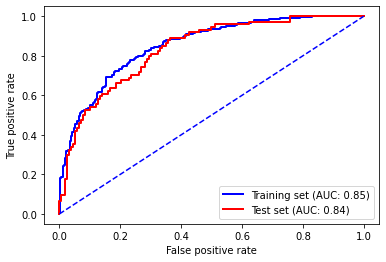

In [122]:
#Model + new threshold
q,w,e,r,t,yh,u,p = Training(hid_layer1 = 3, hid_layer2 = None, alpha = 0.4, function = "tanh",
                                X = X_train, y = y_train, X_test = X_test, y_test = y_test, 
                                Lambda=0.0, Max_iter = 5000, flag=True)
EE, y_pred, F = Accuracy(theta1=w, theta2=e, theta3=r, X=X_test, y=y_test,function = "tanh")
    

#New prediction (based on the new threshold)
Newpred = EE.copy()
Newpred = np.where(Newpred>=Thresh[Index],1,0)
    
    
#Confusion matrix
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, Newpred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test, Newpred))
print("\nPrecision: ", precision_score(y_test, Newpred))
print("Recall: ", recall_score(y_test, Newpred))
print("F1-score: ", f1_score(y_test, Newpred))
print("\n")
print(Conf_matrix)


#ROC curves
EE1, y_pred2, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train, function = "tanh")
fpr1, tpr1, thresholds1 = roc_curve(y_train,EE1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,EE)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,EE1)),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,EE))], loc="lower right")

Accuracy:  0.7748917748917749

Precision:  0.6896551724137931
Recall:  0.5405405405405406
F1-score:  0.6060606060606061


          Predicted 0  Predicted 1
Actual 0          139           18
Actual 1           34           40


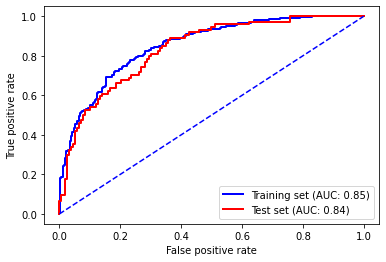

In [123]:
#Confusion matrix (no threshold modification)
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("\nPrecision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1-score: ", f1_score(y_test, y_pred))
print("\n")
print(Conf_matrix)

#ROC curves (no threshold modification)
EE1, y_pred2, F = Accuracy(theta1=w, theta2=e, X=X_train, y=y_train, function = "tanh")
fpr1, tpr1, thresholds1 = roc_curve(y_train,EE1)
fpr2, tpr2, thresholds2 = roc_curve(y_test,EE)
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,EE1)),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,EE))], loc="lower right")

.

Without the threshold modification, the accuracy on the test set is higher. However, the number of true positives is lower.

.

For comparison, let's use the Logistic regression model (no threshold modification).



Logistic training accuracy:  0.7653631284916201
Logistic test accuracy:  0.7792207792207793

Precision:  0.7090909090909091
Recall:  0.527027027027027
F1-score:  0.6046511627906976




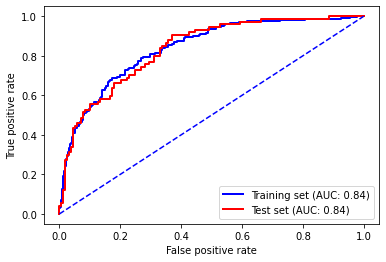

In [124]:
#Logistic regression
Model_log = LogisticRegression(penalty="none").fit(X_train,y_train)
print("\n\nLogistic training accuracy: ", Model_log.score(X_train,y_train))
print("Logistic test accuracy: ", Model_log.score(X_test,y_test))
y_pred_log = Model_log.predict(X_test)

#Confusion matrix
Conf_matrix_log = pd.DataFrame(confusion_matrix(y_test, y_pred_log))
Conf_matrix_log.index=["Actual 0", "Actual 1"]
Conf_matrix_log.columns=["Predicted 0", "Predicted 1"]
print("\nPrecision: ", precision_score(y_test, y_pred_log))
print("Recall: ", recall_score(y_test, y_pred_log))
print("F1-score: ", f1_score(y_test, y_pred_log))
print("\n")
Conf_matrix_log

#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train,Model_log.predict_proba(X_train)[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test,Model_log.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,Model_log.predict_proba(X_train)[:,1])),
            "Test set (AUC: {:.2f})".format(roc_auc_score(y_test,Model_log.predict_proba(X_test)[:,1]))], loc="lower right")

.

.

.

# **Neural Network with KERAS**

Now, let's try to use Keras to build different Neural Networks.

2022-04-20 18:49:10.074078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-20 18:49:10.074159: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 18:49:10.074212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (samuele-300E5EV-300E4EV-270E5EV-270E4EV): /proc/driver/nvidia/version does not exist


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 27        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________

Last iteration:  317
Training accuracy:  0.7552447319030762
Validation accuracy:  0.7592592835426331


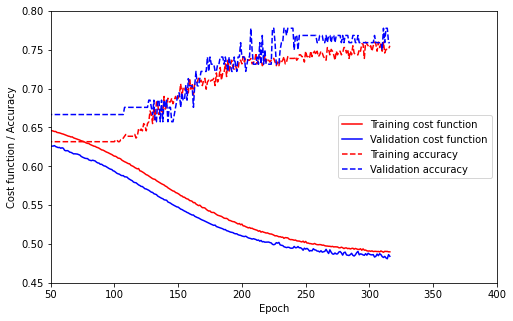

In [125]:
#Creation of X and y (from the unbalanced dataset)
X = data.drop(["Class"],axis=1)
y = data.Class
X = np.array(X)
y = np.array(y)

#Training and test set (70-30%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#Feature scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#EXAMPLE
#Neural Network model with one hidden layer (of 3 units)
Model = Sequential()
Model.add(Dense(units=3, input_shape=X_train.shape[1:]))
Model.add(Activation("sigmoid"))
Model.add(Dense(units=1, activation="sigmoid"))             #One output (0 or 1)
Model.summary()

#Training
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)          #Early stopping
Epochs = 500
Model.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss="binary_crossentropy",metrics=["accuracy"])
Run = Model.fit(X_train, y_train, validation_split=0.2, epochs=Epochs, verbose=0, callbacks=[callback],shuffle=True)

#Results
print("\nLast iteration: ", len(Run.history["loss"]))
print("Training accuracy: ", Run.history["accuracy"][-1])
print("Validation accuracy: ", Run.history["val_accuracy"][-1])

#Plot: accuracy curves
plt.figure(figsize=(8,5))
plt.plot(Run.history["loss"],'-r')
plt.plot(Run.history["val_loss"],"-b")
plt.plot(Run.history["accuracy"],'--r')
plt.plot(Run.history["val_accuracy"],"--b")
plt.xlim([50,400])
plt.ylim([0.45,0.80])
plt.xlabel("Epoch")
plt.ylabel("Cost function / Accuracy")
plt.legend(["Training cost function","Validation cost function","Training accuracy","Validation accuracy"])

.

Let's search for the best set of hyperparameters with a grid search. The output will be:
 - Number of units in the hidden layer(s)
 - Learning rate
 - Activation function
 - Mean accuracy on the training set (standard deviation)
 - Mean accuracy on the test set (standard deviation)
 - Mean precision
 - Mean recall
 - Mean F1-score
 - Mean training AUC
 - Mean test AUC

In [126]:
#Grid search
hid_layer1 = [2,3,5]
hid_layer2 = [None, 2,5]
learning_rate = [0.5,0.8,1.0]
functions = ["sigmoid","tanh","relu"]
for i in hid_layer1 :
    for j in hid_layer2 :
        for a in learning_rate :
            for f in functions :
            #Model structure
                if j == None :
                    Model = Sequential()
                    Model.add(Dense(units=i, input_shape=X_train.shape[1:]))
                    Model.add(Activation(f))
                    Model.add(Dense(units=1, activation="sigmoid"))             #One output (0 or 1)
                else :
                    Model = Sequential()
                    Model.add(Dense(units=i, input_shape=X_train.shape[1:]))
                    Model.add(Activation(f))
                    Model.add(Dense(units=j))
                    Model.add(Activation(f))
                    Model.add(Dense(units=1, activation="sigmoid"))             #One output (0 or 1)
                #Training
                callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)       #Early stopping
                Epochs = 1000
                Model.compile(optimizer=keras.optimizers.SGD(lr=a),loss="binary_crossentropy",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(),keras.metrics.AUC()])
                acc, acc_te, pre, rec, auc, auc_te = [], [], [], [], [], []
                for k in range(5) :
                    Run = Model.fit(X_train, y_train, validation_split=0.2, epochs=Epochs, verbose=0, callbacks=[callback], shuffle = True)
                    acc.append(Run.history["accuracy"][-1]), acc_te.append(Run.history["val_accuracy"][-1])
                    pre.append(Run.history[list(Run.history)[7]][-1]),rec.append(Run.history[list(Run.history)[8]][-1])
                    auc.append(Run.history[list(Run.history)[4]][-1])
                    auc_te.append(Run.history[list(Run.history)[9]][-1])
                    
                print("{} - {} - {} - {} ----- {:.3f} ({:.3f}) - {:.3f} ({:.3f}) --- {:.3f} - {:.3f} - {:.3f} --- {:.3f} - {:.3f}".format(i,j,a,f,
                                                                                                    np.mean(acc),np.std(acc),np.mean(acc_te),np.std(acc_te),
                                                                                                    np.mean(pre), np.mean(rec),
                                                                                                    2*(np.mean(pre)*np.mean(rec))/(np.mean(pre)+np.mean(rec)),
                                                                                                    np.mean(auc), np.mean(auc_te)))

2 - None - 0.5 - sigmoid ----- 0.769 (0.006) - 0.781 (0.009) --- 0.752 - 0.517 - 0.612 --- 0.834 - 0.824
2 - None - 0.5 - tanh ----- 0.772 (0.014) - 0.798 (0.016) --- 0.800 - 0.556 - 0.656 --- 0.843 - 0.840
2 - None - 0.5 - relu ----- 0.761 (0.005) - 0.781 (0.014) --- 0.782 - 0.483 - 0.597 --- 0.824 - 0.831
2 - None - 0.8 - sigmoid ----- 0.763 (0.003) - 0.778 (0.006) --- 0.694 - 0.600 - 0.644 --- 0.830 - 0.828
2 - None - 0.8 - tanh ----- 0.756 (0.013) - 0.741 (0.048) --- 0.624 - 0.678 - 0.650 --- 0.815 - 0.822
2 - None - 0.8 - relu ----- 0.763 (0.013) - 0.752 (0.038) --- 0.832 - 0.417 - 0.555 --- 0.836 - 0.819
2 - None - 1.0 - sigmoid ----- 0.752 (0.017) - 0.737 (0.031) --- 0.697 - 0.500 - 0.582 --- 0.822 - 0.824
2 - None - 1.0 - tanh ----- 0.768 (0.008) - 0.752 (0.026) --- 0.769 - 0.461 - 0.577 --- 0.832 - 0.835
2 - None - 1.0 - relu ----- 0.766 (0.005) - 0.693 (0.120) --- 0.668 - 0.678 - 0.673 --- 0.830 - 0.812
2 - 2 - 0.5 - sigmoid ----- 0.735 (0.052) - 0.761 (0.048) --- 0.559 - 0.5

.

The best model (i.e. high validation AUC, high validation accuracy, high f1-score, precision and recall, small std on accuracies) is
- Number of units in the first hidden layer: 2
- Number of units in the second hidden layer: None
- Learning rate: 0.5
- Activation function: tanh

.

Let's take a look at the performance on the Test set


Last iteration:  22
Training accuracy:  0.7653631567955017
Test accuracy:  0.7705627679824829

Test precision:  0.7142857313156128
Test recall:  0.47297295928001404
Test f1-score:  0.5691056865498235

           Predicted 0  Predicted 1
Actual 0          143           14
Actual 1           39           35


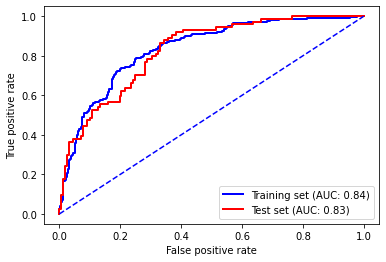

In [127]:
#Best model
Model1 = Sequential()
Model1.add(Dense(units=2, input_shape=X_train.shape[1:]))
Model1.add(Activation("tanh"))
Model1.add(Dense(units=1, activation="sigmoid"))             #One output (0 or 1)

#Training
Model1.compile(optimizer=keras.optimizers.SGD(lr=0.5),loss="binary_crossentropy",metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
Run = Model1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=Epochs, verbose=0, callbacks=[callback])

#Results
print("\nLast iteration: ", len(Run.history["loss"]))
print("Training accuracy: ", Run.history["accuracy"][-1])
print("Test accuracy: ", Run.history["val_accuracy"][-1])
print("\nTest precision: ", Run.history[list(Run.history)[6]][-1])
print("Test recall: ", Run.history[list(Run.history)[7]][-1])
print("Test f1-score: ", 2*((Run.history[list(Run.history)[6]][-1])*(Run.history[list(Run.history)[7]][-1]))/((Run.history[list(Run.history)[6]][-1])+(Run.history[list(Run.history)[7]][-1])))

#Confusion matrix (the function "predict_classes" does not exist anymore)
Pred = Model1.predict(X_test)
Newpred = Pred.copy()
Newpred = np.where(Newpred>=0.5,1,0)    
Conf_matrix = pd.DataFrame(confusion_matrix(y_test, Newpred))
Conf_matrix.index=["Actual 0", "Actual 1"]
Conf_matrix.columns=["Predicted 0", "Predicted 1"]
print("\n",Conf_matrix)

#ROC curves
fpr1, tpr1, thresholds1 = roc_curve(y_train,Model1.predict(X_train))
fpr2, tpr2, thresholds2 = roc_curve(y_test,Model1.predict(X_test))
plt.plot(fpr1, tpr1,'blue',lw=2)
plt.plot(fpr2, tpr2,'red',lw=2)
plt.plot([0,1],[0,1],'--b')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["Training set (AUC: {:.2f})".format(roc_auc_score(y_train,Model1.predict(X_train))),"Test set (AUC: {:.2f})".format(roc_auc_score(y_test,Model1.predict(X_test)))], loc="lower right")